# Kaggle tabular playground sept 2021
**Juan Andrés Toro Delgado**

- Preprocessing, EDA, and classification of dataset using various models

In [1]:
import numpy as np
import pandas as pd
import random
import pandas_profiling
import matplotlib.pyplot as plt
import gc

gc.enable()

## Import data
- Subset of all data
- EDA with pandas_profiling

In [2]:
# Select randon subsample from csv
filename='./data/tabular-playground-sept-2021/train.csv'
# with open(filename) as f:
#     n = sum(1 for line in f) - 1 #number of records in file (excludes header)
# s = 100000 #desired sample size
# skip = sorted(random.sample(range(1,n+1),n-s))
train_df = pd.read_csv('./data/tabular-playground-sept-2021/train.csv')#, header=0, skiprows=skip)
train_df.head(5)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [8]:
profile = pandas_profiling.ProfileReport(train_df, title='Pandas Profiling of train_df',minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/128 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Preprocessing and dimensionality reduction

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='constant', fill_value=0.0)),
    ('scaler',StandardScaler())
])

train_np = train_df[train_df.columns[1:-1]].to_numpy()

train_np = pipeline.fit_transform(train_np)
print(train_np.shape)

(957919, 118)


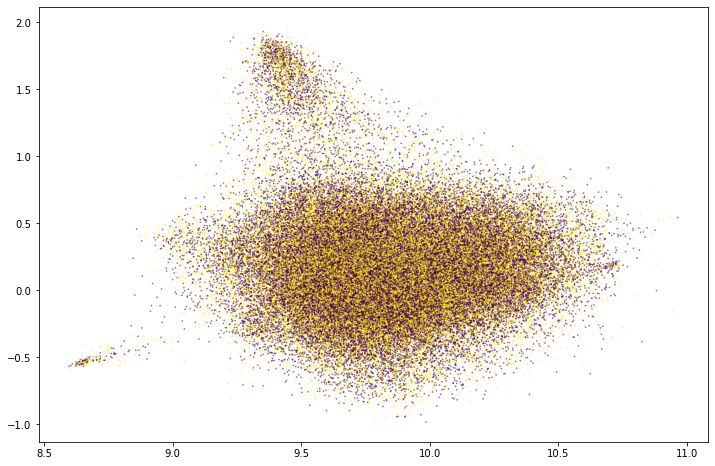

In [44]:
import umap
reducer = umap.UMAP(n_components=12)
embedding = reducer.fit_transform(train_np)
plt.figure(figsize=(12,8))
plt.scatter(embedding[:,0],embedding[:,1],c=train_df['claim'],s=0.5,alpha=0.5)
plt.show()

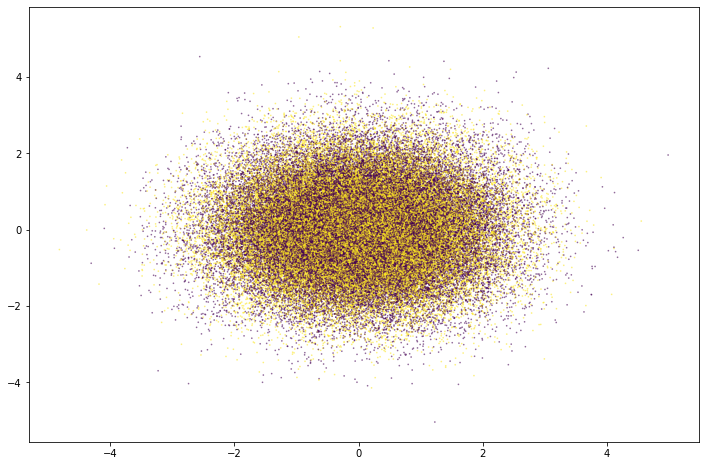

In [36]:
from sklearn.decomposition import PCA

pca = PCA()
train_np_pca = pca.fit_transform(train_np)

plt.figure(figsize=(12,8))
plt.scatter(train_np_pca[:,0],train_np_pca[:,1],c=train_df['claim'],s=0.5,alpha=0.5)
plt.show()

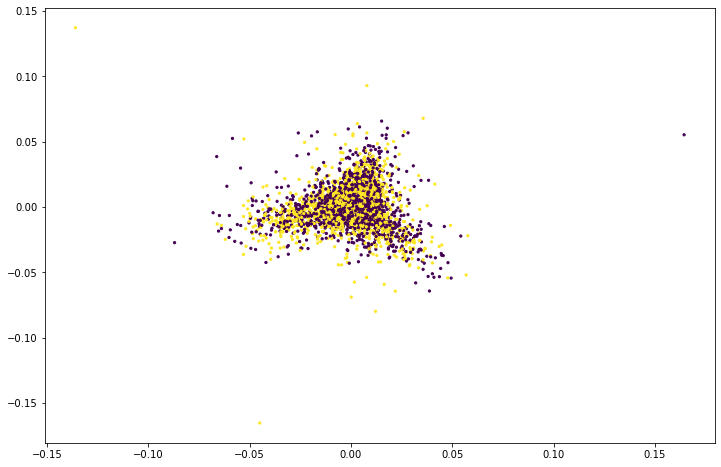

In [43]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15)
train_np_lle = lle.fit_transform(train_np[:5000])

plt.figure(figsize=(12,8))
plt.scatter(train_np_lle[:,0],train_np_lle[:,1],c=train_df['claim'][:5000],s=5,alpha=1)
plt.show()

## Classification models
- Split data into train_test
- Train stratified dummy classifier
- Test out various classifiers (linear, trees, ensemble, gradient boosting)

In [4]:
# Train test split
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_np,train_df['claim'],test_size=0.2,random_state=42)
x_test, y_test = (x_val[:int(0.5*len(x_val))], y_val[:int(0.5*len(y_val))]) 
x_val, y_val = (x_val[int(0.5*len(x_val)):], y_val[int(0.5*len(y_val)):]) 

# x_train = reducer.fit_transform(x_train)
# x_val = reducer.transform(x_val)
# x_test = reducer.transform(x_test)

In [62]:
# Dummy classifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='stratified',random_state=42)
dummy_clf.fit(x_train,y_train)
dummy_clf.score(x_val,y_val)

0.4927

### Linear models

In [29]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)

scores = cross_val_score(log_reg, x_train, y_train,cv=3,scoring='roc_auc',n_jobs=-1)

print("Average roc auc score:", scores.mean())
print('Accuracy on validation set:',log_reg.score(x_val,y_val))

Average roc auc score: 0.5844083997100511
Accuracy on validation set: 0.5523


In [30]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(x_train,y_train)

scores = cross_val_score(sgd_clf, x_train, y_train,cv=3,scoring='roc_auc',n_jobs=-1)

print("Average roc auc score:", scores.mean())
print('Accuracy on validation set:',sgd_clf.score(x_val,y_val))

Average roc auc score: 0.5563884764955135
Accuracy on validation set: 0.5375


In [31]:
from sklearn.linear_model import RidgeClassifier

ridge_clf = RidgeClassifier()
ridge_clf.fit(x_train,y_train)

scores = cross_val_score(ridge_clf, x_train, y_train,cv=3,scoring='roc_auc',n_jobs=-1)

print("Average roc auc score:", scores.mean())
print('Accuracy on validation set:',ridge_clf.score(x_val,y_val))

Average roc auc score: 0.5844339846865262
Accuracy on validation set: 0.5527


In [32]:
from sklearn.linear_model import Perceptron

per_clf = Perceptron()
per_clf.fit(x_train,y_train)

scores = cross_val_score(per_clf, x_train, y_train,cv=3,scoring='roc_auc',n_jobs=-1)

print("Average roc auc score:", scores.mean())
print('Accuracy on validation set:',per_clf.score(x_val,y_val))

Average roc auc score: 0.5137158782697401
Accuracy on validation set: 0.5126


### Decision Trees and Ensemble methods

In [34]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(x_train,y_train)

scores = cross_val_score(tree_clf, x_train, y_train,cv=3,scoring='roc_auc',n_jobs=-1)

print("Average roc auc score:", scores.mean())
print('Accuracy on validation set:',tree_clf.score(x_val,y_val))

Average roc auc score: 0.5708496326857007
Accuracy on validation set: 0.5801


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rnd_clf = RandomForestClassifier(n_estimators=10, max_samples=30000, n_jobs=-1)
rnd_clf.fit(x_train,y_train)

scores = cross_val_score(rnd_clf, x_train, y_train,cv=3,scoring='roc_auc',n_jobs=-1)

print("Average roc auc score:", scores.mean())
print('Accuracy on validation set:',rnd_clf.score(x_val,y_val))

Accuracy: 0.5902
Average roc auc score: 0.6229728909889727


In [6]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
# svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf)],# ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier())])

In [8]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.5336
RandomForestClassifier 0.5338
VotingClassifier 0.5293


### Catboost - GPU accelerated gradient boosting 

In [12]:
from catboost import CatBoostClassifier

cboost_clf = CatBoostClassifier(iterations=10000,
                                depth=8,
                                learning_rate=0.075,
                                eval_metric='AUC',
                                loss_function='Logloss',
                                verbose=True,
                                task_type='GPU')

In [13]:
cboost_clf.fit(x_train,y_train,eval_set=(x_val,y_val),early_stopping_rounds=100)
cboost_clf.score(x_val,y_val)

0:	learn: 0.5573262	test: 0.5551324	best: 0.5551324 (0)	total: 37.9ms	remaining: 6m 19s
1:	learn: 0.5919938	test: 0.5895002	best: 0.5895002 (1)	total: 77.8ms	remaining: 6m 28s
2:	learn: 0.6072467	test: 0.6051748	best: 0.6051748 (2)	total: 119ms	remaining: 6m 35s
3:	learn: 0.6072444	test: 0.6053057	best: 0.6053057 (3)	total: 157ms	remaining: 6m 32s
4:	learn: 0.6072261	test: 0.6052682	best: 0.6053057 (3)	total: 195ms	remaining: 6m 29s
5:	learn: 0.6072225	test: 0.6052980	best: 0.6053057 (3)	total: 233ms	remaining: 6m 28s
6:	learn: 0.6072096	test: 0.6053958	best: 0.6053958 (6)	total: 273ms	remaining: 6m 29s
7:	learn: 0.6215190	test: 0.6196974	best: 0.6196974 (7)	total: 310ms	remaining: 6m 26s
8:	learn: 0.6298863	test: 0.6279172	best: 0.6279172 (8)	total: 351ms	remaining: 6m 29s
9:	learn: 0.6371690	test: 0.6347982	best: 0.6347982 (9)	total: 390ms	remaining: 6m 29s
10:	learn: 0.6405393	test: 0.6383229	best: 0.6383229 (10)	total: 428ms	remaining: 6m 28s
11:	learn: 0.6437240	test: 0.6416225	be

97:	learn: 0.7578824	test: 0.7548037	best: 0.7548037 (97)	total: 4.09s	remaining: 6m 53s
98:	learn: 0.7579398	test: 0.7548589	best: 0.7548589 (98)	total: 4.14s	remaining: 6m 53s
99:	learn: 0.7580910	test: 0.7550081	best: 0.7550081 (99)	total: 4.18s	remaining: 6m 53s
100:	learn: 0.7584191	test: 0.7553361	best: 0.7553361 (100)	total: 4.22s	remaining: 6m 53s
101:	learn: 0.7584516	test: 0.7553632	best: 0.7553632 (101)	total: 4.26s	remaining: 6m 53s
102:	learn: 0.7586831	test: 0.7556129	best: 0.7556129 (102)	total: 4.3s	remaining: 6m 53s
103:	learn: 0.7593050	test: 0.7560328	best: 0.7560328 (103)	total: 4.35s	remaining: 6m 54s
104:	learn: 0.7599640	test: 0.7567561	best: 0.7567561 (104)	total: 4.39s	remaining: 6m 53s
105:	learn: 0.7607449	test: 0.7575217	best: 0.7575217 (105)	total: 4.43s	remaining: 6m 53s
106:	learn: 0.7610899	test: 0.7578374	best: 0.7578374 (106)	total: 4.48s	remaining: 6m 54s
107:	learn: 0.7612175	test: 0.7579823	best: 0.7579823 (107)	total: 4.52s	remaining: 6m 54s
108:	l

189:	learn: 0.7816368	test: 0.7776356	best: 0.7776356 (189)	total: 8.04s	remaining: 6m 55s
190:	learn: 0.7817605	test: 0.7777308	best: 0.7777308 (190)	total: 8.09s	remaining: 6m 55s
191:	learn: 0.7820445	test: 0.7780566	best: 0.7780566 (191)	total: 8.13s	remaining: 6m 55s
192:	learn: 0.7823240	test: 0.7783052	best: 0.7783052 (192)	total: 8.17s	remaining: 6m 55s
193:	learn: 0.7824171	test: 0.7783825	best: 0.7783825 (193)	total: 8.22s	remaining: 6m 55s
194:	learn: 0.7826150	test: 0.7785359	best: 0.7785359 (194)	total: 8.26s	remaining: 6m 55s
195:	learn: 0.7828582	test: 0.7787693	best: 0.7787693 (195)	total: 8.31s	remaining: 6m 55s
196:	learn: 0.7829615	test: 0.7788705	best: 0.7788705 (196)	total: 8.35s	remaining: 6m 55s
197:	learn: 0.7831966	test: 0.7791418	best: 0.7791418 (197)	total: 8.4s	remaining: 6m 55s
198:	learn: 0.7834366	test: 0.7793665	best: 0.7793665 (198)	total: 8.44s	remaining: 6m 55s
199:	learn: 0.7836907	test: 0.7796333	best: 0.7796333 (199)	total: 8.49s	remaining: 6m 56s


281:	learn: 0.7933456	test: 0.7884943	best: 0.7884943 (281)	total: 12.1s	remaining: 6m 56s
282:	learn: 0.7934456	test: 0.7885744	best: 0.7885744 (282)	total: 12.1s	remaining: 6m 56s
283:	learn: 0.7934663	test: 0.7885722	best: 0.7885744 (282)	total: 12.2s	remaining: 6m 56s
284:	learn: 0.7935010	test: 0.7885988	best: 0.7885988 (284)	total: 12.2s	remaining: 6m 56s
285:	learn: 0.7935472	test: 0.7885832	best: 0.7885988 (284)	total: 12.3s	remaining: 6m 56s
286:	learn: 0.7935864	test: 0.7886105	best: 0.7886105 (286)	total: 12.3s	remaining: 6m 57s
287:	learn: 0.7936488	test: 0.7886636	best: 0.7886636 (287)	total: 12.4s	remaining: 6m 56s
288:	learn: 0.7937906	test: 0.7887898	best: 0.7887898 (288)	total: 12.4s	remaining: 6m 56s
289:	learn: 0.7938496	test: 0.7888443	best: 0.7888443 (289)	total: 12.4s	remaining: 6m 56s
290:	learn: 0.7939163	test: 0.7888928	best: 0.7888928 (290)	total: 12.5s	remaining: 6m 56s
291:	learn: 0.7939523	test: 0.7889106	best: 0.7889106 (291)	total: 12.5s	remaining: 6m 56s

375:	learn: 0.7981668	test: 0.7917715	best: 0.7917715 (375)	total: 16.3s	remaining: 6m 55s
376:	learn: 0.7982019	test: 0.7917573	best: 0.7917715 (375)	total: 16.3s	remaining: 6m 56s
377:	learn: 0.7982324	test: 0.7917584	best: 0.7917715 (375)	total: 16.3s	remaining: 6m 56s
378:	learn: 0.7982668	test: 0.7917820	best: 0.7917820 (378)	total: 16.4s	remaining: 6m 56s
379:	learn: 0.7983170	test: 0.7918192	best: 0.7918192 (379)	total: 16.4s	remaining: 6m 56s
380:	learn: 0.7983599	test: 0.7918242	best: 0.7918242 (380)	total: 16.5s	remaining: 6m 56s
381:	learn: 0.7983979	test: 0.7918122	best: 0.7918242 (380)	total: 16.5s	remaining: 6m 56s
382:	learn: 0.7984250	test: 0.7918302	best: 0.7918302 (382)	total: 16.6s	remaining: 6m 56s
383:	learn: 0.7984609	test: 0.7918364	best: 0.7918364 (383)	total: 16.6s	remaining: 6m 56s
384:	learn: 0.7985234	test: 0.7919020	best: 0.7919020 (384)	total: 16.7s	remaining: 6m 56s
385:	learn: 0.7986054	test: 0.7919836	best: 0.7919836 (385)	total: 16.7s	remaining: 6m 56s

467:	learn: 0.8015272	test: 0.7931936	best: 0.7931936 (467)	total: 20.4s	remaining: 6m 54s
468:	learn: 0.8015792	test: 0.7932237	best: 0.7932237 (468)	total: 20.4s	remaining: 6m 54s
469:	learn: 0.8016257	test: 0.7932328	best: 0.7932328 (469)	total: 20.4s	remaining: 6m 54s
470:	learn: 0.8016422	test: 0.7932341	best: 0.7932341 (470)	total: 20.5s	remaining: 6m 54s
471:	learn: 0.8016964	test: 0.7932369	best: 0.7932369 (471)	total: 20.5s	remaining: 6m 54s
472:	learn: 0.8017355	test: 0.7932615	best: 0.7932615 (472)	total: 20.6s	remaining: 6m 54s
473:	learn: 0.8017560	test: 0.7932767	best: 0.7932767 (473)	total: 20.6s	remaining: 6m 54s
474:	learn: 0.8017748	test: 0.7932841	best: 0.7932841 (474)	total: 20.7s	remaining: 6m 54s
475:	learn: 0.8018199	test: 0.7932931	best: 0.7932931 (475)	total: 20.7s	remaining: 6m 54s
476:	learn: 0.8018444	test: 0.7933082	best: 0.7933082 (476)	total: 20.8s	remaining: 6m 54s
477:	learn: 0.8018565	test: 0.7933134	best: 0.7933134 (477)	total: 20.8s	remaining: 6m 54s

560:	learn: 0.8045953	test: 0.7941715	best: 0.7941733 (557)	total: 24.6s	remaining: 6m 53s
561:	learn: 0.8046311	test: 0.7941685	best: 0.7941733 (557)	total: 24.6s	remaining: 6m 53s
562:	learn: 0.8046475	test: 0.7941790	best: 0.7941790 (562)	total: 24.7s	remaining: 6m 53s
563:	learn: 0.8046809	test: 0.7941703	best: 0.7941790 (562)	total: 24.7s	remaining: 6m 53s
564:	learn: 0.8047222	test: 0.7941652	best: 0.7941790 (562)	total: 24.7s	remaining: 6m 53s
565:	learn: 0.8047411	test: 0.7941729	best: 0.7941790 (562)	total: 24.8s	remaining: 6m 53s
566:	learn: 0.8047595	test: 0.7941928	best: 0.7941928 (566)	total: 24.8s	remaining: 6m 53s
567:	learn: 0.8047862	test: 0.7942032	best: 0.7942032 (567)	total: 24.9s	remaining: 6m 53s
568:	learn: 0.8048273	test: 0.7942127	best: 0.7942127 (568)	total: 24.9s	remaining: 6m 53s
569:	learn: 0.8048443	test: 0.7942204	best: 0.7942204 (569)	total: 25s	remaining: 6m 53s
570:	learn: 0.8048753	test: 0.7942414	best: 0.7942414 (570)	total: 25s	remaining: 6m 53s
571

651:	learn: 0.8072913	test: 0.7946878	best: 0.7946878 (651)	total: 28.8s	remaining: 6m 52s
652:	learn: 0.8073137	test: 0.7946872	best: 0.7946878 (651)	total: 28.8s	remaining: 6m 52s
653:	learn: 0.8073402	test: 0.7947124	best: 0.7947124 (653)	total: 28.9s	remaining: 6m 52s
654:	learn: 0.8073848	test: 0.7947575	best: 0.7947575 (654)	total: 28.9s	remaining: 6m 52s
655:	learn: 0.8074057	test: 0.7947557	best: 0.7947575 (654)	total: 29s	remaining: 6m 52s
656:	learn: 0.8074246	test: 0.7947730	best: 0.7947730 (656)	total: 29s	remaining: 6m 52s
657:	learn: 0.8074446	test: 0.7947791	best: 0.7947791 (657)	total: 29s	remaining: 6m 52s
658:	learn: 0.8074712	test: 0.7947775	best: 0.7947791 (657)	total: 29.1s	remaining: 6m 52s
659:	learn: 0.8075063	test: 0.7947857	best: 0.7947857 (659)	total: 29.1s	remaining: 6m 52s
660:	learn: 0.8075417	test: 0.7947881	best: 0.7947881 (660)	total: 29.2s	remaining: 6m 52s
661:	learn: 0.8075620	test: 0.7947973	best: 0.7947973 (661)	total: 29.2s	remaining: 6m 52s
662:	

742:	learn: 0.8099114	test: 0.7951480	best: 0.7951538 (734)	total: 33s	remaining: 6m 51s
743:	learn: 0.8099429	test: 0.7951520	best: 0.7951538 (734)	total: 33s	remaining: 6m 51s
744:	learn: 0.8099694	test: 0.7951692	best: 0.7951692 (744)	total: 33.1s	remaining: 6m 51s
745:	learn: 0.8099827	test: 0.7951685	best: 0.7951692 (744)	total: 33.1s	remaining: 6m 50s
746:	learn: 0.8100100	test: 0.7951619	best: 0.7951692 (744)	total: 33.2s	remaining: 6m 50s
747:	learn: 0.8100356	test: 0.7951634	best: 0.7951692 (744)	total: 33.2s	remaining: 6m 50s
748:	learn: 0.8100696	test: 0.7951778	best: 0.7951778 (748)	total: 33.3s	remaining: 6m 50s
749:	learn: 0.8100982	test: 0.7951680	best: 0.7951778 (748)	total: 33.3s	remaining: 6m 50s
750:	learn: 0.8101276	test: 0.7951568	best: 0.7951778 (748)	total: 33.4s	remaining: 6m 50s
751:	learn: 0.8101670	test: 0.7951735	best: 0.7951778 (748)	total: 33.4s	remaining: 6m 50s
752:	learn: 0.8101828	test: 0.7951749	best: 0.7951778 (748)	total: 33.5s	remaining: 6m 50s
753

834:	learn: 0.8126598	test: 0.7954238	best: 0.7954238 (834)	total: 37.3s	remaining: 6m 49s
835:	learn: 0.8126841	test: 0.7954284	best: 0.7954284 (835)	total: 37.4s	remaining: 6m 49s
836:	learn: 0.8127237	test: 0.7954206	best: 0.7954284 (835)	total: 37.4s	remaining: 6m 49s
837:	learn: 0.8127496	test: 0.7954191	best: 0.7954284 (835)	total: 37.5s	remaining: 6m 49s
838:	learn: 0.8127782	test: 0.7954094	best: 0.7954284 (835)	total: 37.5s	remaining: 6m 49s
839:	learn: 0.8128150	test: 0.7954215	best: 0.7954284 (835)	total: 37.5s	remaining: 6m 49s
840:	learn: 0.8128386	test: 0.7954231	best: 0.7954284 (835)	total: 37.6s	remaining: 6m 49s
841:	learn: 0.8128711	test: 0.7954180	best: 0.7954284 (835)	total: 37.6s	remaining: 6m 49s
842:	learn: 0.8128759	test: 0.7954164	best: 0.7954284 (835)	total: 37.7s	remaining: 6m 49s
843:	learn: 0.8129076	test: 0.7954153	best: 0.7954284 (835)	total: 37.7s	remaining: 6m 49s
844:	learn: 0.8129265	test: 0.7954332	best: 0.7954332 (844)	total: 37.8s	remaining: 6m 49s

926:	learn: 0.8153461	test: 0.7955359	best: 0.7955421 (923)	total: 41.7s	remaining: 6m 47s
927:	learn: 0.8153843	test: 0.7955771	best: 0.7955771 (927)	total: 41.7s	remaining: 6m 47s
928:	learn: 0.8154073	test: 0.7955806	best: 0.7955806 (928)	total: 41.8s	remaining: 6m 47s
929:	learn: 0.8154360	test: 0.7955816	best: 0.7955816 (929)	total: 41.8s	remaining: 6m 47s
930:	learn: 0.8154664	test: 0.7955698	best: 0.7955816 (929)	total: 41.8s	remaining: 6m 47s
931:	learn: 0.8154974	test: 0.7955788	best: 0.7955816 (929)	total: 41.9s	remaining: 6m 47s
932:	learn: 0.8155190	test: 0.7955863	best: 0.7955863 (932)	total: 41.9s	remaining: 6m 47s
933:	learn: 0.8155252	test: 0.7955922	best: 0.7955922 (933)	total: 42s	remaining: 6m 47s
934:	learn: 0.8155576	test: 0.7956009	best: 0.7956009 (934)	total: 42s	remaining: 6m 47s
935:	learn: 0.8155766	test: 0.7956004	best: 0.7956009 (934)	total: 42.1s	remaining: 6m 47s
936:	learn: 0.8156173	test: 0.7955980	best: 0.7956009 (934)	total: 42.1s	remaining: 6m 47s
937

1020:	learn: 0.8180555	test: 0.7958335	best: 0.7958359 (1019)	total: 46.1s	remaining: 6m 45s
1021:	learn: 0.8180898	test: 0.7958235	best: 0.7958359 (1019)	total: 46.2s	remaining: 6m 45s
1022:	learn: 0.8181276	test: 0.7958367	best: 0.7958367 (1022)	total: 46.2s	remaining: 6m 45s
1023:	learn: 0.8181684	test: 0.7958273	best: 0.7958367 (1022)	total: 46.3s	remaining: 6m 45s
1024:	learn: 0.8182064	test: 0.7958339	best: 0.7958367 (1022)	total: 46.3s	remaining: 6m 45s
1025:	learn: 0.8182469	test: 0.7958401	best: 0.7958401 (1025)	total: 46.4s	remaining: 6m 45s
1026:	learn: 0.8182679	test: 0.7958355	best: 0.7958401 (1025)	total: 46.4s	remaining: 6m 45s
1027:	learn: 0.8183013	test: 0.7958418	best: 0.7958418 (1027)	total: 46.4s	remaining: 6m 45s
1028:	learn: 0.8183344	test: 0.7958487	best: 0.7958487 (1028)	total: 46.5s	remaining: 6m 45s
1029:	learn: 0.8183631	test: 0.7958457	best: 0.7958487 (1028)	total: 46.5s	remaining: 6m 45s
1030:	learn: 0.8183993	test: 0.7958412	best: 0.7958487 (1028)	total: 4

1111:	learn: 0.8208805	test: 0.7959589	best: 0.7959668 (1078)	total: 50.5s	remaining: 6m 43s
1112:	learn: 0.8209127	test: 0.7959553	best: 0.7959668 (1078)	total: 50.6s	remaining: 6m 43s
1113:	learn: 0.8209465	test: 0.7959488	best: 0.7959668 (1078)	total: 50.6s	remaining: 6m 43s
1114:	learn: 0.8209816	test: 0.7959551	best: 0.7959668 (1078)	total: 50.7s	remaining: 6m 43s
1115:	learn: 0.8210092	test: 0.7959611	best: 0.7959668 (1078)	total: 50.7s	remaining: 6m 43s
1116:	learn: 0.8210286	test: 0.7959549	best: 0.7959668 (1078)	total: 50.8s	remaining: 6m 43s
1117:	learn: 0.8210559	test: 0.7959595	best: 0.7959668 (1078)	total: 50.8s	remaining: 6m 43s
1118:	learn: 0.8210873	test: 0.7959517	best: 0.7959668 (1078)	total: 50.9s	remaining: 6m 43s
1119:	learn: 0.8211195	test: 0.7959450	best: 0.7959668 (1078)	total: 50.9s	remaining: 6m 43s
1120:	learn: 0.8211541	test: 0.7959332	best: 0.7959668 (1078)	total: 51s	remaining: 6m 43s
1121:	learn: 0.8211810	test: 0.7959223	best: 0.7959668 (1078)	total: 51s

1201:	learn: 0.8234687	test: 0.7960116	best: 0.7960346 (1196)	total: 54.9s	remaining: 6m 41s
1202:	learn: 0.8235006	test: 0.7960097	best: 0.7960346 (1196)	total: 54.9s	remaining: 6m 41s
1203:	learn: 0.8235334	test: 0.7960088	best: 0.7960346 (1196)	total: 55s	remaining: 6m 41s
1204:	learn: 0.8235533	test: 0.7960131	best: 0.7960346 (1196)	total: 55s	remaining: 6m 41s
1205:	learn: 0.8235720	test: 0.7960122	best: 0.7960346 (1196)	total: 55.1s	remaining: 6m 41s
1206:	learn: 0.8236086	test: 0.7960131	best: 0.7960346 (1196)	total: 55.1s	remaining: 6m 41s
1207:	learn: 0.8236409	test: 0.7960061	best: 0.7960346 (1196)	total: 55.2s	remaining: 6m 41s
1208:	learn: 0.8236781	test: 0.7960119	best: 0.7960346 (1196)	total: 55.2s	remaining: 6m 41s
1209:	learn: 0.8237105	test: 0.7960134	best: 0.7960346 (1196)	total: 55.3s	remaining: 6m 41s
1210:	learn: 0.8237404	test: 0.7960108	best: 0.7960346 (1196)	total: 55.3s	remaining: 6m 41s
1211:	learn: 0.8237749	test: 0.7960051	best: 0.7960346 (1196)	total: 55.3s

1292:	learn: 0.8262151	test: 0.7958699	best: 0.7960346 (1196)	total: 59.3s	remaining: 6m 39s
1293:	learn: 0.8262470	test: 0.7958749	best: 0.7960346 (1196)	total: 59.4s	remaining: 6m 39s
1294:	learn: 0.8262675	test: 0.7958696	best: 0.7960346 (1196)	total: 59.4s	remaining: 6m 39s
1295:	learn: 0.8262991	test: 0.7958637	best: 0.7960346 (1196)	total: 59.5s	remaining: 6m 39s
1296:	learn: 0.8263211	test: 0.7958673	best: 0.7960346 (1196)	total: 59.5s	remaining: 6m 39s
bestTest = 0.7960345745
bestIteration = 1196
Shrink model to first 1197 iterations.


0.7323054117254051

In [15]:
cboost_clf.score(x_val,y_val)

0.7323054117254051

In [14]:
cboost_clf.score(x_test,y_test)

0.730812593953566

In [17]:
test_df = pd.read_csv('./data/tabular-playground-sept-2021/test.csv')
test_np = test_df[test_df.columns[1:]].to_numpy()

test_np = pipeline.transform(test_np)
print(test_np.shape)

(493474, 118)


In [20]:
test_proba = cboost_clf.predict_proba(test_np)
out_df = pd.DataFrame({'id':test_df['id'],'claim':test_proba[:,1]})
out_df.to_csv('./data/tabular-playground-sept-2021/results_catbooost.csv',index=False)